In [2]:
%load_ext tikzmagic

In [3]:
import tfo_parser_ulambda as ul
import IPython.display


g_parser = ul.parser()

def f_pretty(txt):
    return g_parser.parse(txt).pretty()

f_list_flatten = lambda lists: reduce(lambda a,b: a+b, lists)
f_latex_std_abstr = lambda children_out: f_list_flatten((['(', '\\lambda'], [children_out[0]], ['.'], children_out[1:], [')']))
f_latex_std_appl = lambda children_out: f_list_flatten((['['], children_out, [']']))
f_latex_2d_abstr = lambda children_out: f_list_flatten((['\dfrac{'], [children_out[0]], ['}{'], children_out[1:], ['}']))
f_latex_2d_appl = lambda children_out: children_out
g_latex_style_std = {}
g_latex_style_2d = {'abstr':f_latex_2d_abstr, 'appl':f_latex_2d_appl}

def f_latex(txt, style = {}):
    func_abstr = style.get('abstr', f_latex_std_abstr)
    func_appl = style.get('appl', f_latex_std_appl)
    def recurse(node):
        if type(node) == ul.lark.tree.Tree:
            if node.data not in ['variable', 'term']:
                children_out = f_list_flatten([recurse(x) for x in node.children])
                if node.data == 'abstraction':
                    return func_abstr(children_out)
                elif node.data == 'application':
                    return func_appl(children_out)
            else:
                return recurse(node.children[0])
        else:
            return [str(node)]
    return ' '.join(recurse(g_parser.parse(txt)))

def f_disp_latex(txt, style = {}):
    IPython.display.display(IPython.display.Latex('${}$'.format(f_latex(txt, style))))



In [5]:
display(IPython.display.Latex('${}$'.format(f_latex('[x.[y z]]'))))
display(IPython.display.Latex('${}$'.format(f_latex('[x.[x z]]', g_latex_style_2d))))
f_disp_latex('[x.[y z]]')
f_disp_latex('[x.[y z]]', g_latex_style_2d)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [38]:
def f_tree(txt):
    def recurse(node):
        if type(node) == ul.lark.tree.Tree:
            if node.data not in ['variable', 'term']:
                return {'type':node.data, 'kids':[recurse(x) for x in node.children]}
            else:
                return recurse(node.children[0])
        else:
            return {'type':'var', 'name' : str(node)}
    root = recurse(g_parser.parse(txt))
    return root

def f_tikz_tree(txt):
    make_node = lambda name: 'node{{{}}}'.format(name)
    make_child = lambda node: 'child{{{}}}'.format(node)
    make_kid_nodes = lambda kids: ' '.join([make_child(kid) for kid in kids])
    def recurse(node, pars=('{', '}')):
        if node['type'] not in ['var']:
            children_out = [recurse(x) for x in node['kids']]
            return ' '.join([ ''.join([pars[0], make_node(node['type'])]), make_kid_nodes(children_out), pars[1]])
        else:
            return make_node(node['name'])
    tikz_code = recurse(f_tree(txt), ('\\',';'))
    return tikz_code

def f_disp_tikz_tree(txt, style = {}):
    IPython.get_ipython().run_cell('%%tikz\n' + f_tikz_tree(txt))
    
#f_tree('[x.(y z)]')
#f_tikz_tree('[x.(y z)]')
#f_tikz_tree('[x y]')
#f_tikz_tree('[x. y]')
print f_tikz_tree('[y z]')

print f_tikz_tree('[x. [y z]]')

\node{application} child{node{y}} child{node{z}} ;
\node{abstraction} child{node{x}} child{{node{application} child{node{y}} child{node{z}} }} ;


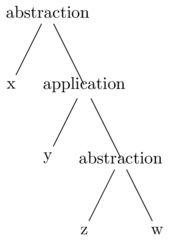

In [41]:
f_disp_tikz_tree('[x. [y [z. w]]]')

In [96]:
if False:
    %%tikz
    IPython.display.display('''
    \node {root}
        child {node {left}
          child {node {lleft}}
          child {node {rleft}}
        }
        child {node {right}
        child {node {lright}}
          child {node {rright}}
        };''')